## Import dependencies


In [119]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

import seaborn as sns

## Read data

In [218]:
X_train = pd.read_csv("../data/train_test_val/X_train.csv", header=[0], index_col=0).reset_index(drop=True)
X_test = pd.read_csv("../data/train_test_val/X_test.csv", header=[0], index_col=0).reset_index(drop=True)
X_val = pd.read_csv("../data/train_test_val/X_val.csv", header=[0], index_col=0).reset_index(drop=True)

y_train = pd.read_csv("../data/train_test_val/y_train.csv", index_col=0) .reset_index(drop=True).values.reshape(-1)
y_val = pd.read_csv("../data/train_test_val/y_val.csv", index_col = 0).reset_index(drop=True).values.reshape(-1)
y_test = pd.read_csv("../data/train_test_val/y_test.csv", index_col = 0).reset_index(drop=True).values.reshape(-1)

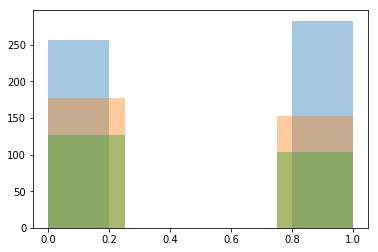

In [219]:
sns.distplot(y_train, kde=False)
sns.distplot(y_val, kde=False)
sns.distplot(y_test, kde=False)

### Creating ML Pipeline

In [220]:
rfc = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
knc = KNeighborsClassifier()
abc = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
gnb = GaussianNB()
# lr = LogisticRegressionCV(max_iter=500, random_state=42)

models = {"rfc": rfc,"svc": svc, "knc" : knc,
          "abc" : abc, "gbc" : gbc, "gnb" :gnb}

In [221]:
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train.drop(["measurementID","id_gps"], axis=1)) 
scaled_X_val = scaler.fit_transform(X_val.drop(["measurementID","id_gps"], axis=1))
scaled_X_test = scaler.fit_transform(X_test.drop(["measurementID","id_gps"], axis=1))

In [222]:
X_train = X_train.drop(["measurementID","id_gps"], axis=1)
X_val = X_val.drop(["measurementID","id_gps"], axis=1)
X_test = X_test.drop(["measurementID","id_gps"], axis=1)
y_train = np.ravel(y_train.values)
y_val = np.ravel(y_val.values)
y_test = np.ravel(y_test.values)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

Metrics on Validation Dataset:


Accuracy rfc: 0.9516616314199395
Precision rfc: 0.9520146405908789
Recall rfc: 0.9516616314199395
F1 Score rfc: 0.9516988420409139


Cross Validation on Test Dataset:


rfc accuracy is 95.67±5.50


Test Scores:
 min: 0.8260869565217391
 max: 1.0
 delta: 0.17391304347826086


********************


Metrics on Validation Dataset:


Accuracy svc: 0.48942598187311176
Precision svc: 0.7084386157648997
Recall svc: 0.48942598187311176
F1 Score svc: 0.3539879664379067


Cross Validation on Test Dataset:


svc accuracy is 54.98±1.96


Test Scores:
 min: 0.5217391304347826
 max: 0.5652173913043478
 delta: 0.04347826086956519


********************


Metrics on Validation Dataset:


Accuracy knc: 0.7824773413897281
Precision knc: 0.7851536880838377
Recall knc: 0.7824773413897281
F1 Score knc: 0.7827875426361008


Cross Validation on Test Dataset:


knc accuracy is 69.66±8.35


Test Scores:
 min: 0.5652173913043478
 max: 0.7916666666666666
 delta: 0.226449275362318

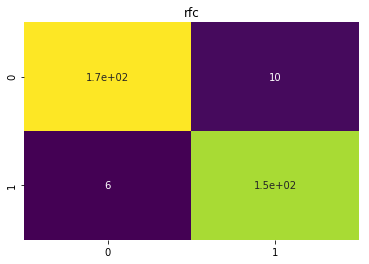

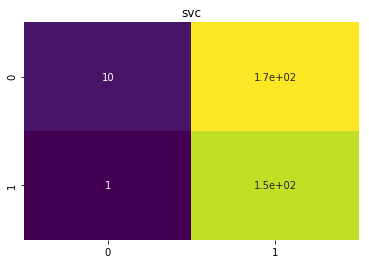

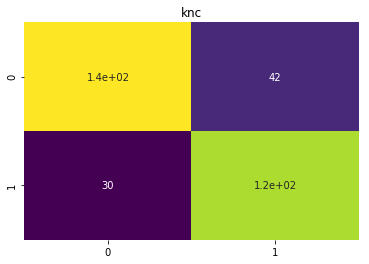

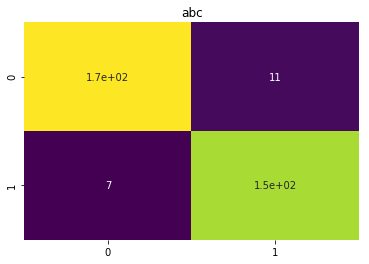

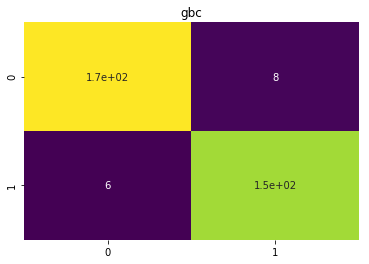

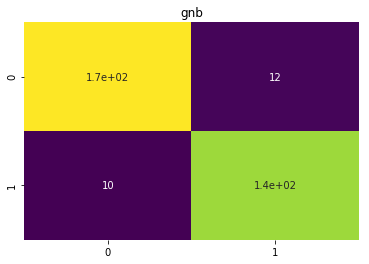

In [224]:
for m in models:
    
    model = models[m].fit(X_train, y_train)
    preds = model.predict(X_val)
      
    accuracy = accuracy_score(y_val,preds)
    precision = precision_score(y_val,preds,average="weighted")
    recall = recall_score(y_val,preds, average="weighted")
    f1 = f1_score(y_val, preds, average="weighted")
    
    print("Metrics on Validation Dataset:")
    print("\n")
    
    print(f"Accuracy {m}: {accuracy}")
    print(f"Precision {m}: {precision}")
    print(f"Recall {m}: {recall}")
    print(f"F1 Score {m}: {f1}")
    
    print("\n")
    print("Cross Validation on Test Dataset:")
    print("\n")
    cv = cross_validate(model,
                        X =  X_test,
                        y = np.ravel(y_test),
                        cv = 10)

    print("{} accuracy is {:.2f}±{:.2f}".format(m,cv["test_score"].mean()*100,cv["test_score"].std()*100))

    
    print("\n")
    print("Test Scores:\n min: {}\n max: {}\n delta: {}"\
          .format(cv["test_score"].min(), 
                  cv["test_score"].max(),
                  cv["test_score"].max()-cv["test_score"].min()))
    print("\n")
    print("*"*20)
    print("\n")
    
    cm = confusion_matrix(y_val,preds)
    
    fig = plt.figure()
    fig = plt.title(m)
    sns.heatmap(cm, cmap="viridis", annot= True, cbar = False)

## Hyperparameter tuning

In [225]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Cross Validation

In [226]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [227]:
cv = cross_validate(rfc,
               X =  X_test,
               y = np.ravel(y_test))

print("Model accuracy is {:.2f}±{:.2f}".format(cv["test_score"].mean()*100,cv["test_score"].std()*100))
print(cv)

Model accuracy is 94.37±6.39
{'fit_time': array([0.30882025, 0.2318871 , 0.24683905, 0.26782537, 0.24787736]), 'score_time': array([0.01798987, 0.01698995, 0.01701021, 0.01399493, 0.01696754]), 'test_score': array([0.95744681, 0.82608696, 1.        , 0.93478261, 1.        ])}


In [228]:
cm = confusion_matrix(y_val,preds)

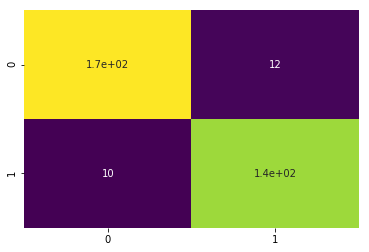

In [229]:
sns.heatmap(cm, cmap="viridis", annot= True, cbar = False)

## Save the model

In [148]:
from joblib import dump, load
dump(rfc, '../models/rfc_v13.joblib') 

['../models/rfc_v13.joblib']

## Eval


In [230]:
from processing_funcs import *
from scipy.stats import norm, kurtosis
from scipy import signal
import glob

In [314]:
df = read_all(1/50)

ok = df[df["label"] == 0]
nok = df[df["label"] == 1]

In [353]:
test = read_measurement("../data/raw_data_train/test/*", 1/50)

In [354]:
def kurtosis_time(x):

    return kurtosis(x, fisher=True)

def rms_100(x):

    return np.sqrt(np.mean(x**2))

def crest(x):

    return max(abs(x))/np.sqrt(np.mean(x**2))

def create_aggregated(df):
    """Create a aggregated dataframe in time domain"""
    signals = ['x_lin_acc', 'y_lin_acc', "z_lin_acc", 
               'x_acc', 'y_acc', 'z_acc',
               'x_gyro', 'y_gyro', 'z_gyro']

    agg_df = df.groupby(["measurementID","id_gps"]).agg({x: ["sum", "mean", "mad",
                                                "median", "min", "max",
                                                "std", "var", "sem",
                                                "skew", "quantile",
                                                kurtosis_time, rms_100,
                                                crest] for x in signals})
    
    new_cols = []
    
    for k,i in enumerate(agg_df.columns):
        
        new_cols.append(i[0] + "_" +  i[1])

    agg_df.columns = new_cols
    
    return agg_df

In [355]:
feature_df = create_aggregated(test).reset_index()

In [356]:
pred = rfc.predict(feature_df.drop(["measurementID", "id_gps"], axis = 1))

In [357]:
map_df = pd.concat([test[["measurementID", "id_gps", "lat", "lon"]]\
                    .groupby(["measurementID","id_gps"])\
                    .max()\
                    .reset_index(), 
                    pd.DataFrame({"label" : pred})], axis=1)

In [358]:
map_df

,measurementID,id_gps,lat,lon,label
0,0,6,47.686660,17.649326,0
1,0,7,47.686671,17.649232,0
2,0,8,47.686762,17.649229,0
3,0,49,47.687627,17.648372,0
4,0,50,47.687688,17.648309,0
...,...,...,...,...,...
296,0,405,47.702993,17.630514,0
297,0,406,47.703137,17.630560,0
298,0,407,47.703278,17.630605,0
299,0,408,47.703420,17.630652,1


In [359]:
fig = go.Figure()
fig = px.scatter_mapbox(map_df, 
                        lat="lat", 
                        lon="lon",
                        zoom = 11, 
                        height=500, 
                        color = "label", 
                        color_continuous_scale=["green","red"])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.layout.coloraxis.showscale = False
fig